<a href="https://colab.research.google.com/github/issam9/finetuning-bert-models-for-arabic-dialect-detection/blob/main/finetune_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning Arabert, Dziribert and Bert Arabic for Dialect Detection

In [1]:
!nvidia-smi

Sat Oct 16 14:46:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    81W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/aub-mind/arabert.git

fatal: destination path 'arabert' already exists and is not an empty directory.


In [3]:
!pip install -q transformers
!pip install -q datasets
!pip install -q wandb
!pip install -q farasapy
!pip install -q pyarabic
!pip install -q emoji

In [4]:
import pandas as pd 

from sklearn.model_selection import train_test_split

from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [5]:
# mount colab
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = Path('/content/drive/MyDrive/ml/projects/msda_dataset/dialect')

In [26]:
df = pd.read_csv(path/'dialect.csv')
df.head()

,Twits,dialect
0,الدكتورة نجوى قامة في القصف الصاروخي لك ان ترى...,Algerian
1,سكيكدة_المجاهدة❤ صورة تجمع أحد أكبر و أعظم زعم...,Algerian
2,😂😂😂😂😂 شكون يعرفها🤔,Algerian
3,يهود الأندلس للاسف جاو زرعوا الفتنة في وسطنا,Algerian
4,اليهود,Algerian


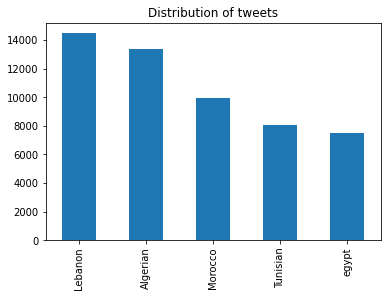

In [33]:
df['dialect'].value_counts()

In [9]:
dialects = df['dialect'].unique()

lbl2idx = {d: i for i, d in enumerate(dialects)}

df['dialect'] = df['dialect'].map(lbl2idx)

In [10]:
df['dialect'].unique()

array([0, 1, 2, 3, 4])

In [11]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Twits'], df['dialect'], random_state=42, 
                                                                    test_size=0.3)

val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, random_state=42, 
                                                                test_size=0.5)

len(train_texts), len(val_texts), len(test_texts)

(37382, 8010, 8011)

### Finetuning arabert

In [ ]:
from arabert.preprocess import ArabertPreprocessor

BERT_MODEL_NAME = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=BERT_MODEL_NAME)

text = train_texts[0]
prep_text = arabert_prep.preprocess(text)
prep_text

[2021-10-15 17:09:44,171 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


'ال+ دكتور +ة نجوى قام +ة في ال+ قصف ال+ صاروخي ل+ +ك ان ترى منشور +ات +ها و+ تدخل +ات +ها'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpw5_6xpqj


Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

storing https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
creating metadata file for /root/.cache/huggingface/transformers/fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

storing https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/da598d10a62ed68f0b95e0c032d813a008518ba8fe1d02fb191884f844c818ce.97462e17e0f13709a0a977021298c2733cda0cb6787facbeeb0b53199a7e73bf
creating metadata file for /root/.cache/huggingface/transformers/da598d10a62ed68f0b95e0c032d813a008518ba8fe1d02fb191884f844c818ce.97462e17e0f13709a0a977021298c2733cda0cb6787facbeeb0b53199a7e73bf
loading weights file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/da598d10a62ed68f0b95e0c032d813a008518ba8fe1d02fb191884f844c818ce.97462e17e0f13709a0a977021298c2733cda0cb6787facbeeb0b53199a7e73bf
Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform

Downloading:   0%|          | 0.00/703k [00:00<?, ?B/s]

storing https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/af6611146fcbc110b4f831c0428e1fbacc46834e6be67ad005d38282b3a55e56.92809ffe5e568c38fb02e34451b1f9b856d049d10a8f967626ebace17c6bc1c9
creating metadata file for /root/.cache/huggingface/transformers/af6611146fcbc110b4f831c0428e1fbacc46834e6be67ad005d38282b3a55e56.92809ffe5e568c38fb02e34451b1f9b856d049d10a8f967626ebace17c6bc1c9
https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpx7s8nhyq


Downloading:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

storing https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/2c79f1586b3719b467d24700b10ea39810a708e15a96d07faac98e6de8e583d2.40f02d215737071e47e240eb2941705eb18edf27b0126deabe245f3f19f2ee24
creating metadata file for /root/.cache/huggingface/transformers/2c79f1586b3719b467d24700b10ea39810a708e15a96d07faac98e6de8e583d2.40f02d215737071e47e240eb2941705eb18edf27b0126deabe245f3f19f2ee24
https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpdbzkzqmp


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/eadd29c2f1c1a9561439797b9dc30dd8a23f506fd13fde84b93b5fa3bde392f7.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/eadd29c2f1c1a9561439797b9dc30dd8a23f506fd13fde84b93b5fa3bde392f7.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpdryoij8d


Downloading:   0%|          | 0.00/611 [00:00<?, ?B/s]

storing https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/9b92fc3002bc77d6c3214a307a407638a9ac0ecb7045096be9599828a5dd2126.8d69c2d6da3751176a19c831b3642f8679a3ff9825be1c07f365a65e652e865c
creating metadata file for /root/.cache/huggingface/transformers/9b92fc3002bc77d6c3214a307a407638a9ac0ecb7045096be9599828a5dd2126.8d69c2d6da3751176a19c831b3642f8679a3ff9825be1c07f365a65e652e865c
loading file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/af6611146fcbc110b4f831c0428e1fbacc46834e6be67ad005d38282b3a55e56.92809ffe5e568c38fb02e34451b1f9b856d049d10a8f967626ebace17c6bc1c9
loading file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/2c79f1586b3719b467d24700b10ea39810a708e15a96d07faac98e6de8e583d2.40f02d215737071e47e240eb2941705eb18edf27b012

In [ ]:
# encode text
tokenizer.batch_encode_plus([prep_text], padding=True, return_token_type_ids=False)

{'input_ids': [[33, 20, 820, 12, 13905, 968, 12, 289, 20, 3505, 20, 6991, 6, 1, 312, 3489, 5715, 4, 10, 29, 1786, 4, 10, 34]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

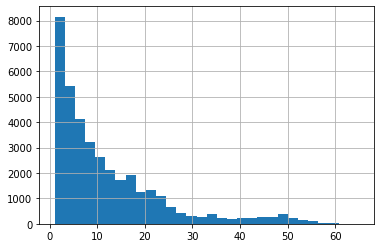

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_texts]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 25

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  

In [ ]:
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [ ]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]),
 'input_ids': tensor([   33, 22573,   162, 14571,   434,  3017, 17046,   440,   357,  1058,
           251,  1116,  6677, 16308,   331, 26354,   200, 38223,   251, 21021,
           219,   162, 12756,   353,    34]),
 'labels': tensor(0),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0])}

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# function to pass to out trainer in order to compute accuracy, f1 score, precision and recall
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    report_to='wandb'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

PyTorch: setting up devices
***** Running training *****
  Num examples = 37382
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5845
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.722000,0.689033,0.739326,0.739326,0.739326,0.739326
2,0.437200,0.616176,0.772285,0.772285,0.772285,0.772285
3,0.404100,0.613149,0.783770,0.783770,0.783770,0.783770
4,0.258200,0.704539,0.791011,0.791011,0.791011,0.791011
5,0.146800,0.787109,0.791261,0.791261,0.791261,0.791261


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in 

TrainOutput(global_step=5845, training_loss=0.47661835353939425, metrics={'train_runtime': 2375.4239, 'train_samples_per_second': 78.685, 'train_steps_per_second': 2.461, 'total_flos': 2401338476950500.0, 'train_loss': 0.47661835353939425, 'epoch': 5.0})

In [ ]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8011
  Batch size = 64


PredictionOutput(predictions=array([[-2.104874  ,  7.1576486 , -2.159453  , -0.6787567 , -2.3933952 ],
       [-0.01939736, -1.5878391 , -2.4740412 ,  7.7732115 , -2.1313672 ],
       [-1.0459899 ,  2.2707698 , -5.398424  , -1.7943295 ,  5.383764  ],
       ...,
       [-0.3340939 , -0.10817923, -2.117448  ,  6.0347013 , -2.2375693 ],
       [-0.12345398,  0.43365428,  0.2800358 ,  0.48806244, -0.40311515],
       [ 7.879965  , -2.4409378 , -1.5282911 , -1.9021562 , -2.034669  ]],
      dtype=float32), label_ids=array([1, 3, 4, ..., 3, 3, 0]), metrics={'test_loss': 0.766575813293457, 'test_accuracy': 0.8243664960679066, 'test_f1': 0.8243664960679066, 'test_precision': 0.8243664960679066, 'test_recall': 0.8243664960679066, 'test_runtime': 23.749, 'test_samples_per_second': 337.32, 'test_steps_per_second': 5.305})

### Finetuning dziribert

In [12]:
BERT_MODEL_NAME = 'alger-ia/dziribert'

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of the model checkpoint at alger-ia/dziribert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/176 [00:00<?, ?B/s]

In [14]:
max_seq_len = 25

In [15]:
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [20]:
train_encodings[0]

Encoding(num_tokens=25, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [16]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [17]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [18]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    evaluation_strategy='epoch',
    report_to='wandb'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

***** Running training *****
  Num examples = 37382
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5845
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.544600,0.470259,0.830087,0.830087,0.830087,0.830087
2,0.319100,0.489107,0.832834,0.832834,0.832834,0.832834
3,0.150900,0.622314,0.840200,0.840200,0.840200,0.840200
4,0.076500,0.850390,0.839201,0.839201,0.839201,0.839201
5,0.038500,0.887370,0.845568,0.845568,0.845568,0.845568


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in 

TrainOutput(global_step=5845, training_loss=0.25069988110414215, metrics={'train_runtime': 2464.9131, 'train_samples_per_second': 75.828, 'train_steps_per_second': 2.371, 'total_flos': 2401338476950500.0, 'train_loss': 0.25069988110414215, 'epoch': 5.0})

In [19]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8011
  Batch size = 64


PredictionOutput(predictions=array([[-2.3625293 ,  7.935675  , -1.4187776 , -1.5907899 , -2.634851  ],
       [-0.8095739 , -2.029526  , -2.7067924 ,  7.8290257 , -1.9284828 ],
       [-2.325295  , -1.8311379 , -3.689361  ,  0.12742263,  6.686925  ],
       ...,
       [-1.3125819 ,  1.6767278 , -1.3233855 ,  5.494418  , -4.1050167 ],
       [-1.0637516 , -2.4735856 ,  3.1865199 ,  0.7601345 , -0.7705013 ],
       [ 8.165027  , -2.139205  , -1.5214015 , -2.3346906 , -2.413062  ]],
      dtype=float32), label_ids=array([1, 3, 4, ..., 3, 3, 0]), metrics={'test_loss': 0.8822937607765198, 'test_accuracy': 0.8428410934964424, 'test_f1': 0.8428410934964424, 'test_precision': 0.8428410934964424, 'test_recall': 0.8428410934964424, 'test_runtime': 25.9654, 'test_samples_per_second': 308.526, 'test_steps_per_second': 4.853})

### Finetuning bert-base-arabic

In [12]:
BERT_MODEL_NAME = 'asafaya/bert-base-arabic'

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-ar

In [14]:
max_seq_len = 25

In [15]:
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [16]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [17]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [18]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    # report_to='wandb'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

***** Running training *****
  Num examples = 37382
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5845
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: issam1 (use `wandb login --relogin` to force relogin)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.827000,0.600420,0.768539,0.768539,0.768539,0.768539
2,0.455100,0.603596,0.786142,0.786142,0.786142,0.786142
3,0.258900,0.670925,0.802497,0.802497,0.802497,0.802497
4,0.148900,0.811274,0.802247,0.802247,0.802247,0.802247
5,0.089900,0.990216,0.809863,0.809863,0.809863,0.809863


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in 

TrainOutput(global_step=5845, training_loss=0.3559465811332135, metrics={'train_runtime': 2341.6719, 'train_samples_per_second': 79.819, 'train_steps_per_second': 2.496, 'total_flos': 2401338476950500.0, 'train_loss': 0.3559465811332135, 'epoch': 5.0})

In [19]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8011
  Batch size = 64


PredictionOutput(predictions=array([[-2.9203129e+00,  7.3646150e+00, -1.6223066e+00, -1.0767794e+00,
        -2.0874398e+00],
       [-9.3266536e-03,  6.7047328e-01, -2.6485603e+00,  5.6929898e+00,
        -2.5990424e+00],
       [-1.9154329e+00, -5.7758558e-01, -2.4327574e+00, -1.8282853e+00,
         7.1013899e+00],
       ...,
       [-2.8917902e+00,  4.9016080e+00, -2.2455933e+00,  3.4851663e+00,
        -2.7986975e+00],
       [ 6.4562649e-02,  6.3554816e-02, -1.3950185e-03, -9.4588082e-03,
        -4.7639567e-01],
       [ 7.3927207e+00, -2.8901663e+00, -2.1047127e+00, -2.2497656e+00,
        -2.1236787e+00]], dtype=float32), label_ids=array([1, 3, 4, ..., 3, 3, 0]), metrics={'test_loss': 0.9903667569160461, 'test_accuracy': 0.8103857196355012, 'test_f1': 0.8103857196355013, 'test_precision': 0.8103857196355012, 'test_recall': 0.8103857196355012, 'test_runtime': 25.9317, 'test_samples_per_second': 308.927, 'test_steps_per_second': 4.859})